# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 18:53 - loss: 0.6953

  21/1875 [..............................] - ETA: 4s - loss: 0.5844   

  42/1875 [..............................] - ETA: 4s - loss: 0.5040

  68/1875 [>.............................] - ETA: 4s - loss: 0.4504

  86/1875 [>.............................] - ETA: 4s - loss: 0.4265

 110/1875 [>.............................] - ETA: 4s - loss: 0.4032

 129/1875 [=>............................] - ETA: 4s - loss: 0.3890

 151/1875 [=>............................] - ETA: 4s - loss: 0.3756

 178/1875 [=>............................] - ETA: 3s - loss: 0.3620

 203/1875 [==>...........................] - ETA: 3s - loss: 0.3514

 222/1875 [==>...........................] - ETA: 3s - loss: 0.3443

 248/1875 [==>...........................] - ETA: 3s - loss: 0.3357

 275/1875 [===>..........................] - ETA: 3s - loss: 0.3278

 302/1875 [===>..........................] - ETA: 3s - loss: 0.3207

 328/1875 [====>.........................] - ETA: 3s - loss: 0.3145

 355/1875 [====>.........................] - ETA: 3s - loss: 0.3086

 381/1875 [=====>........................] - ETA: 3s - loss: 0.3035

 406/1875 [=====>........................] - ETA: 3s - loss: 0.2989

 431/1875 [=====>........................] - ETA: 3s - loss: 0.2946

 454/1875 [======>.......................] - ETA: 3s - loss: 0.2909

 480/1875 [======>.......................] - ETA: 2s - loss: 0.2870

 506/1875 [=======>......................] - ETA: 2s - loss: 0.2833

 533/1875 [=======>......................] - ETA: 2s - loss: 0.2798

 559/1875 [=======>......................] - ETA: 2s - loss: 0.2765

 585/1875 [========>.....................] - ETA: 2s - loss: 0.2734

 611/1875 [========>.....................] - ETA: 2s - loss: 0.2705

 638/1875 [=========>....................] - ETA: 2s - loss: 0.2676

 661/1875 [=========>....................] - ETA: 2s - loss: 0.2653

 686/1875 [=========>....................] - ETA: 2s - loss: 0.2628

 711/1875 [==========>...................] - ETA: 2s - loss: 0.2605

 735/1875 [==========>...................] - ETA: 2s - loss: 0.2583

 760/1875 [===========>..................] - ETA: 2s - loss: 0.2561

 782/1875 [===========>..................] - ETA: 2s - loss: 0.2543

 808/1875 [===========>..................] - ETA: 2s - loss: 0.2522

 833/1875 [============>.................] - ETA: 2s - loss: 0.2503

 858/1875 [============>.................] - ETA: 2s - loss: 0.2484

 883/1875 [=============>................] - ETA: 2s - loss: 0.2466

 907/1875 [=============>................] - ETA: 2s - loss: 0.2449

 932/1875 [=============>................] - ETA: 1s - loss: 0.2432

 958/1875 [==============>...............] - ETA: 1s - loss: 0.2415

 984/1875 [==============>...............] - ETA: 1s - loss: 0.2399

1007/1875 [===============>..............] - ETA: 1s - loss: 0.2385

1032/1875 [===============>..............] - ETA: 1s - loss: 0.2370

1058/1875 [===============>..............] - ETA: 1s - loss: 0.2354

1083/1875 [================>.............] - ETA: 1s - loss: 0.2340

1110/1875 [================>.............] - ETA: 1s - loss: 0.2326

1136/1875 [=================>............] - ETA: 1s - loss: 0.2312

1163/1875 [=================>............] - ETA: 1s - loss: 0.2298

1187/1875 [=================>............] - ETA: 1s - loss: 0.2286

1212/1875 [==================>...........] - ETA: 1s - loss: 0.2273

1239/1875 [==================>...........] - ETA: 1s - loss: 0.2260

1265/1875 [===================>..........] - ETA: 1s - loss: 0.2248

1291/1875 [===================>..........] - ETA: 1s - loss: 0.2236

1317/1875 [====================>.........] - ETA: 1s - loss: 0.2225

1342/1875 [====================>.........] - ETA: 1s - loss: 0.2214

1368/1875 [====================>.........] - ETA: 1s - loss: 0.2203

1393/1875 [=====================>........] - ETA: 0s - loss: 0.2193

1417/1875 [=====================>........] - ETA: 0s - loss: 0.2183

1440/1875 [======================>.......] - ETA: 0s - loss: 0.2174

1466/1875 [======================>.......] - ETA: 0s - loss: 0.2164

1487/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1515/1875 [=======================>......] - ETA: 0s - loss: 0.2145

1538/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1562/1875 [=======================>......] - ETA: 0s - loss: 0.2128

1588/1875 [========================>.....] - ETA: 0s - loss: 0.2119

1610/1875 [========================>.....] - ETA: 0s - loss: 0.2111

1634/1875 [=========================>....] - ETA: 0s - loss: 0.2103

1655/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1675/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1699/1875 [==========================>...] - ETA: 0s - loss: 0.2082

1722/1875 [==========================>...] - ETA: 0s - loss: 0.2075

1746/1875 [==========================>...] - ETA: 0s - loss: 0.2067

1770/1875 [===========================>..] - ETA: 0s - loss: 0.2060

1795/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1819/1875 [============================>.] - ETA: 0s - loss: 0.2045

1837/1875 [============================>.] - ETA: 0s - loss: 0.2040

1860/1875 [============================>.] - ETA: 0s - loss: 0.2033

1875/1875 [==============================] - 5s 2ms/step - loss: 0.2029


Epoch 2/5
   1/1875 [..............................] - ETA: 6s - loss: 0.1146

  26/1875 [..............................] - ETA: 3s - loss: 0.1116

  52/1875 [..............................] - ETA: 3s - loss: 0.1108

  77/1875 [>.............................] - ETA: 3s - loss: 0.1104

 102/1875 [>.............................] - ETA: 3s - loss: 0.1100

 127/1875 [=>............................] - ETA: 3s - loss: 0.1098

 148/1875 [=>............................] - ETA: 3s - loss: 0.1097

 167/1875 [=>............................] - ETA: 3s - loss: 0.1096

 189/1875 [==>...........................] - ETA: 3s - loss: 0.1095

 204/1875 [==>...........................] - ETA: 3s - loss: 0.1094

 219/1875 [==>...........................] - ETA: 3s - loss: 0.1094

 242/1875 [==>...........................] - ETA: 3s - loss: 0.1093

 266/1875 [===>..........................] - ETA: 3s - loss: 0.1092

 291/1875 [===>..........................] - ETA: 3s - loss: 0.1092

 316/1875 [====>.........................] - ETA: 3s - loss: 0.1091

 339/1875 [====>.........................] - ETA: 3s - loss: 0.1090

 363/1875 [====>.........................] - ETA: 3s - loss: 0.1090

 384/1875 [=====>........................] - ETA: 3s - loss: 0.1089

 406/1875 [=====>........................] - ETA: 3s - loss: 0.1089

 430/1875 [=====>........................] - ETA: 3s - loss: 0.1088

 450/1875 [======>.......................] - ETA: 3s - loss: 0.1088

 472/1875 [======>.......................] - ETA: 3s - loss: 0.1088

 495/1875 [======>.......................] - ETA: 3s - loss: 0.1087

 520/1875 [=======>......................] - ETA: 3s - loss: 0.1087

 541/1875 [=======>......................] - ETA: 3s - loss: 0.1086

 567/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 591/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 616/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 641/1875 [=========>....................] - ETA: 2s - loss: 0.1084

 665/1875 [=========>....................] - ETA: 2s - loss: 0.1084

 691/1875 [==========>...................] - ETA: 2s - loss: 0.1083

 712/1875 [==========>...................] - ETA: 2s - loss: 0.1083

 737/1875 [==========>...................] - ETA: 2s - loss: 0.1083

 762/1875 [===========>..................] - ETA: 2s - loss: 0.1082

 783/1875 [===========>..................] - ETA: 2s - loss: 0.1082

 808/1875 [===========>..................] - ETA: 2s - loss: 0.1081

 828/1875 [============>.................] - ETA: 2s - loss: 0.1081

 847/1875 [============>.................] - ETA: 2s - loss: 0.1080

 870/1875 [============>.................] - ETA: 2s - loss: 0.1080

 895/1875 [=============>................] - ETA: 2s - loss: 0.1079

 919/1875 [=============>................] - ETA: 2s - loss: 0.1079

 936/1875 [=============>................] - ETA: 2s - loss: 0.1079

 958/1875 [==============>...............] - ETA: 2s - loss: 0.1078

 982/1875 [==============>...............] - ETA: 2s - loss: 0.1078

1008/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1034/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1058/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1083/1875 [================>.............] - ETA: 1s - loss: 0.1076

1108/1875 [================>.............] - ETA: 1s - loss: 0.1075

1133/1875 [=================>............] - ETA: 1s - loss: 0.1075

1158/1875 [=================>............] - ETA: 1s - loss: 0.1074

1173/1875 [=================>............] - ETA: 1s - loss: 0.1074

1197/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1220/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1245/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1269/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1284/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1308/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1332/1875 [====================>.........] - ETA: 1s - loss: 0.1071

1357/1875 [====================>.........] - ETA: 1s - loss: 0.1071

1380/1875 [=====================>........] - ETA: 1s - loss: 0.1070

1404/1875 [=====================>........] - ETA: 1s - loss: 0.1070

1429/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1453/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1477/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1500/1875 [=======================>......] - ETA: 0s - loss: 0.1068

1524/1875 [=======================>......] - ETA: 0s - loss: 0.1068

1548/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1572/1875 [========================>.....] - ETA: 0s - loss: 0.1067

1597/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1621/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1644/1875 [=========================>....] - ETA: 0s - loss: 0.1066

1668/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1693/1875 [==========================>...] - ETA: 0s - loss: 0.1065

1717/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1741/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1766/1875 [===========================>..] - ETA: 0s - loss: 0.1064

1790/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1812/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1837/1875 [============================>.] - ETA: 0s - loss: 0.1062

1860/1875 [============================>.] - ETA: 0s - loss: 0.1062

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1062


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1086

  25/1875 [..............................] - ETA: 3s - loss: 0.1007

  50/1875 [..............................] - ETA: 3s - loss: 0.1001

  76/1875 [>.............................] - ETA: 3s - loss: 0.0998

 100/1875 [>.............................] - ETA: 3s - loss: 0.0997

 123/1875 [>.............................] - ETA: 3s - loss: 0.0995

 149/1875 [=>............................] - ETA: 3s - loss: 0.0994

 174/1875 [=>............................] - ETA: 3s - loss: 0.0994

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0993

 223/1875 [==>...........................] - ETA: 3s - loss: 0.0993

 249/1875 [==>...........................] - ETA: 3s - loss: 0.0993

 274/1875 [===>..........................] - ETA: 3s - loss: 0.0992

 300/1875 [===>..........................] - ETA: 3s - loss: 0.0992

 325/1875 [====>.........................] - ETA: 3s - loss: 0.0991

 351/1875 [====>.........................] - ETA: 3s - loss: 0.0991

 377/1875 [=====>........................] - ETA: 3s - loss: 0.0991

 402/1875 [=====>........................] - ETA: 2s - loss: 0.0990

 428/1875 [=====>........................] - ETA: 2s - loss: 0.0990

 454/1875 [======>.......................] - ETA: 2s - loss: 0.0990

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0989

 503/1875 [=======>......................] - ETA: 2s - loss: 0.0989

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0989

 552/1875 [=======>......................] - ETA: 2s - loss: 0.0989

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0989

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0988

 629/1875 [=========>....................] - ETA: 2s - loss: 0.0988

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0988

 681/1875 [=========>....................] - ETA: 2s - loss: 0.0988

 707/1875 [==========>...................] - ETA: 2s - loss: 0.0988

 732/1875 [==========>...................] - ETA: 2s - loss: 0.0987

 758/1875 [===========>..................] - ETA: 2s - loss: 0.0987

 777/1875 [===========>..................] - ETA: 2s - loss: 0.0987

 802/1875 [===========>..................] - ETA: 2s - loss: 0.0987

 828/1875 [============>.................] - ETA: 2s - loss: 0.0986

 854/1875 [============>.................] - ETA: 2s - loss: 0.0986

 880/1875 [=============>................] - ETA: 2s - loss: 0.0986

 905/1875 [=============>................] - ETA: 1s - loss: 0.0986

 931/1875 [=============>................] - ETA: 1s - loss: 0.0986

 957/1875 [==============>...............] - ETA: 1s - loss: 0.0986

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0985

1009/1875 [===============>..............] - ETA: 1s - loss: 0.0985

1032/1875 [===============>..............] - ETA: 1s - loss: 0.0985

1057/1875 [===============>..............] - ETA: 1s - loss: 0.0985

1081/1875 [================>.............] - ETA: 1s - loss: 0.0985

1106/1875 [================>.............] - ETA: 1s - loss: 0.0985

1129/1875 [=================>............] - ETA: 1s - loss: 0.0984

1154/1875 [=================>............] - ETA: 1s - loss: 0.0984

1179/1875 [=================>............] - ETA: 1s - loss: 0.0984

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0984

1226/1875 [==================>...........] - ETA: 1s - loss: 0.0984

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0984

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0984

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0984

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0984

1345/1875 [====================>.........] - ETA: 1s - loss: 0.0983

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0983

1394/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1427/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1689/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1824/1875 [============================>.] - ETA: 0s - loss: 0.0981

1847/1875 [============================>.] - ETA: 0s - loss: 0.0981

1871/1875 [============================>.] - ETA: 0s - loss: 0.0981

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0981


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0957

  24/1875 [..............................] - ETA: 4s - loss: 0.0965

  48/1875 [..............................] - ETA: 4s - loss: 0.0962

  71/1875 [>.............................] - ETA: 3s - loss: 0.0962

  94/1875 [>.............................] - ETA: 3s - loss: 0.0964

 117/1875 [>.............................] - ETA: 3s - loss: 0.0966

 140/1875 [=>............................] - ETA: 3s - loss: 0.0967

 164/1875 [=>............................] - ETA: 3s - loss: 0.0968

 188/1875 [==>...........................] - ETA: 3s - loss: 0.0969

 212/1875 [==>...........................] - ETA: 3s - loss: 0.0969

 236/1875 [==>...........................] - ETA: 3s - loss: 0.0969

 259/1875 [===>..........................] - ETA: 3s - loss: 0.0969

 277/1875 [===>..........................] - ETA: 3s - loss: 0.0969

 300/1875 [===>..........................] - ETA: 3s - loss: 0.0969

 322/1875 [====>.........................] - ETA: 3s - loss: 0.0969

 338/1875 [====>.........................] - ETA: 3s - loss: 0.0969

 360/1875 [====>.........................] - ETA: 3s - loss: 0.0969

 380/1875 [=====>........................] - ETA: 3s - loss: 0.0969

 403/1875 [=====>........................] - ETA: 3s - loss: 0.0968

 425/1875 [=====>........................] - ETA: 3s - loss: 0.0968

 448/1875 [======>.......................] - ETA: 3s - loss: 0.0968

 467/1875 [======>.......................] - ETA: 3s - loss: 0.0968

 486/1875 [======>.......................] - ETA: 3s - loss: 0.0968

 508/1875 [=======>......................] - ETA: 3s - loss: 0.0968

 527/1875 [=======>......................] - ETA: 3s - loss: 0.0968

 548/1875 [=======>......................] - ETA: 3s - loss: 0.0968

 565/1875 [========>.....................] - ETA: 3s - loss: 0.0968

 585/1875 [========>.....................] - ETA: 3s - loss: 0.0967

 605/1875 [========>.....................] - ETA: 3s - loss: 0.0967

 625/1875 [=========>....................] - ETA: 2s - loss: 0.0967

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0967

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0967

 681/1875 [=========>....................] - ETA: 2s - loss: 0.0967

 701/1875 [==========>...................] - ETA: 2s - loss: 0.0967

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0967

 749/1875 [==========>...................] - ETA: 2s - loss: 0.0967

 766/1875 [===========>..................] - ETA: 2s - loss: 0.0967

 790/1875 [===========>..................] - ETA: 2s - loss: 0.0967

 814/1875 [============>.................] - ETA: 2s - loss: 0.0967

 838/1875 [============>.................] - ETA: 2s - loss: 0.0966

 862/1875 [============>.................] - ETA: 2s - loss: 0.0966

 883/1875 [=============>................] - ETA: 2s - loss: 0.0966

 907/1875 [=============>................] - ETA: 2s - loss: 0.0966

 931/1875 [=============>................] - ETA: 2s - loss: 0.0966

 954/1875 [==============>...............] - ETA: 2s - loss: 0.0966

 977/1875 [==============>...............] - ETA: 2s - loss: 0.0966

1001/1875 [===============>..............] - ETA: 2s - loss: 0.0966

1024/1875 [===============>..............] - ETA: 2s - loss: 0.0966

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0966

1065/1875 [================>.............] - ETA: 1s - loss: 0.0966

1085/1875 [================>.............] - ETA: 1s - loss: 0.0966

1106/1875 [================>.............] - ETA: 1s - loss: 0.0966

1131/1875 [=================>............] - ETA: 1s - loss: 0.0965

1153/1875 [=================>............] - ETA: 1s - loss: 0.0965

1177/1875 [=================>............] - ETA: 1s - loss: 0.0965

1195/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1260/1875 [===================>..........] - ETA: 1s - loss: 0.0965

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0965



1304/1875 [===================>..........] - ETA: 1s - loss: 0.0965

1325/1875 [====================>.........] - ETA: 1s - loss: 0.0965

1349/1875 [====================>.........] - ETA: 1s - loss: 0.0965

1375/1875 [=====================>........] - ETA: 1s - loss: 0.0965

1401/1875 [=====================>........] - ETA: 1s - loss: 0.0965

1427/1875 [=====================>........] - ETA: 1s - loss: 0.0964

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1501/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1829/1875 [============================>.] - ETA: 0s - loss: 0.0964

1842/1875 [============================>.] - ETA: 0s - loss: 0.0963

1863/1875 [============================>.] - ETA: 0s - loss: 0.0963

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0963


Epoch 5/5
   1/1875 [..............................] - ETA: 6s - loss: 0.1019

  14/1875 [..............................] - ETA: 7s - loss: 0.0982

  33/1875 [..............................] - ETA: 5s - loss: 0.0969

  48/1875 [..............................] - ETA: 5s - loss: 0.0965

  71/1875 [>.............................] - ETA: 5s - loss: 0.0961

  95/1875 [>.............................] - ETA: 4s - loss: 0.0959

 119/1875 [>.............................] - ETA: 4s - loss: 0.0958

 144/1875 [=>............................] - ETA: 4s - loss: 0.0957

 169/1875 [=>............................] - ETA: 4s - loss: 0.0957

 195/1875 [==>...........................] - ETA: 3s - loss: 0.0956

 221/1875 [==>...........................] - ETA: 3s - loss: 0.0956

 244/1875 [==>...........................] - ETA: 3s - loss: 0.0956

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0956

 290/1875 [===>..........................] - ETA: 3s - loss: 0.0956

 312/1875 [===>..........................] - ETA: 3s - loss: 0.0956

 329/1875 [====>.........................] - ETA: 3s - loss: 0.0956

 352/1875 [====>.........................] - ETA: 3s - loss: 0.0956

 375/1875 [=====>........................] - ETA: 3s - loss: 0.0956

 399/1875 [=====>........................] - ETA: 3s - loss: 0.0956

 421/1875 [=====>........................] - ETA: 3s - loss: 0.0956

 444/1875 [======>.......................] - ETA: 3s - loss: 0.0957

 468/1875 [======>.......................] - ETA: 3s - loss: 0.0956

 490/1875 [======>.......................] - ETA: 3s - loss: 0.0956

 514/1875 [=======>......................] - ETA: 3s - loss: 0.0956

 534/1875 [=======>......................] - ETA: 3s - loss: 0.0956

 558/1875 [=======>......................] - ETA: 3s - loss: 0.0956

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 605/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 627/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 700/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 726/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 767/1875 [===========>..................] - ETA: 2s - loss: 0.0956

 784/1875 [===========>..................] - ETA: 2s - loss: 0.0956

 805/1875 [===========>..................] - ETA: 2s - loss: 0.0956

 821/1875 [============>.................] - ETA: 2s - loss: 0.0956

 845/1875 [============>.................] - ETA: 2s - loss: 0.0956

 869/1875 [============>.................] - ETA: 2s - loss: 0.0956

 891/1875 [=============>................] - ETA: 2s - loss: 0.0956

 912/1875 [=============>................] - ETA: 2s - loss: 0.0956

 932/1875 [=============>................] - ETA: 2s - loss: 0.0956

 959/1875 [==============>...............] - ETA: 2s - loss: 0.0956

 984/1875 [==============>...............] - ETA: 2s - loss: 0.0956

 999/1875 [==============>...............] - ETA: 2s - loss: 0.0956

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1040/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1065/1875 [================>.............] - ETA: 1s - loss: 0.0956

1088/1875 [================>.............] - ETA: 1s - loss: 0.0955

1104/1875 [================>.............] - ETA: 1s - loss: 0.0955

1123/1875 [================>.............] - ETA: 1s - loss: 0.0955

1140/1875 [=================>............] - ETA: 1s - loss: 0.0955

1160/1875 [=================>............] - ETA: 1s - loss: 0.0955

1175/1875 [=================>............] - ETA: 1s - loss: 0.0955

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1309/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1332/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1349/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1389/1875 [=====================>........] - ETA: 1s - loss: 0.0955

1411/1875 [=====================>........] - ETA: 1s - loss: 0.0955

1436/1875 [=====================>........] - ETA: 1s - loss: 0.0955

1455/1875 [======================>.......] - ETA: 1s - loss: 0.0955

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1501/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1520/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1543/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1821/1875 [============================>.] - ETA: 0s - loss: 0.0955

1845/1875 [============================>.] - ETA: 0s - loss: 0.0955

1870/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 5s 2ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

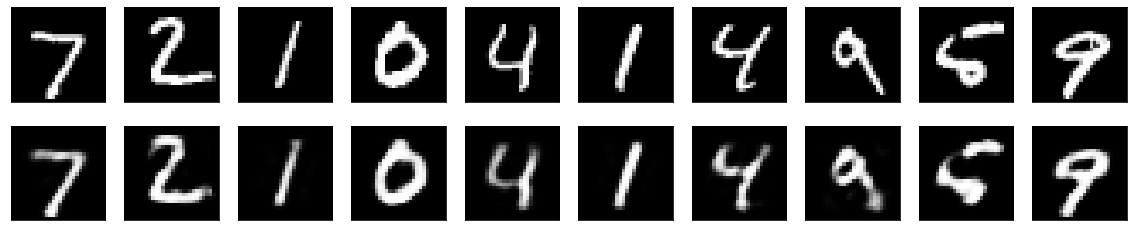

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
